In [2]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import gensim, scipy, nltk
from collections import Counter
from sklearn.datasets import fetch_20newsgroups
nltk.download('stopwords')
%matplotlib inline
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
#有中文出现的情况，需要u'内容'


D:\Anaconda\envs\python36\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gamewin7\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


## 数据集探索

In [3]:
train_news = fetch_20newsgroups(subset='train')
test_news = fetch_20newsgroups(subset='test')
print(train_news.data[0])
print(train_news.data[1])
print(train_news.data[100])
print(train_news.target_names)
print(train_news.target.shape)
print(test_news.target.shape)

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----





From: guykuo@carson.u.washington.edu (Guy Kuo)
Subject: SI Clock Poll - Final Call
Summary: Final call for SI clock reports
Keywords: SI,acceleration,clock,upgrade
Article-I.D.: shelley.1qvfo9INNc3s
Organization: University of Washington
Lines: 11
NNTP-Posting-Host: carson.u.wa

* 数据集由sklearn导入，已经将其分成了测试集和训练集两部分，其中训练集有11314个样本，测试集有7532个样本，数据集已经分为了20个样本了。
* 每篇样本文档可以看作电子邮件文档，有来信人，正文，结束语等结构

## 新闻数据探索可视化

In [4]:
categories = ['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware']
sub_train_news = fetch_20newsgroups(subset='train', categories=categories)
sub_test_news = fetch_20newsgroups(subset='test',categories=categories)

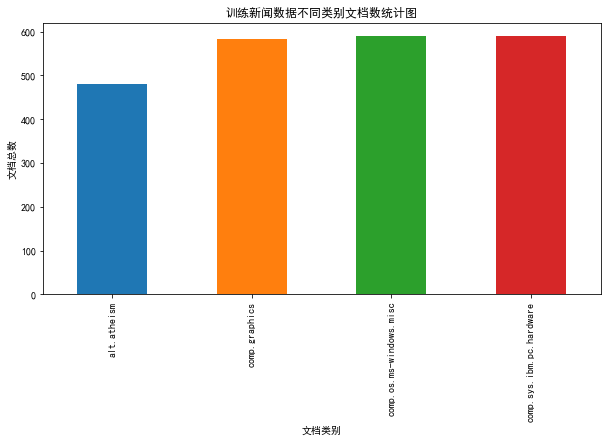

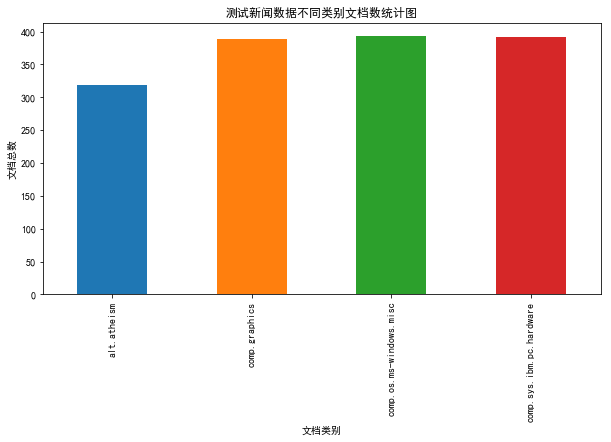

In [4]:
# 观察不同分类的文档数量分布
df = pd.DataFrame(sub_train_news.target, columns=['category'], dtype=np.int8)
sum = df['category'].groupby(df['category']).count()
sum.index = sub_train_news.target_names
sum.plot(kind = 'bar',figsize=(10, 5))
plt.title('训练新闻数据不同类别文档数统计图')
plt.xlabel('文档类别')
plt.ylabel('文档总数')
plt.show()

df = pd.DataFrame(sub_test_news.target, columns=['category'], dtype=np.int8)
sum = df['category'].groupby(df['category']).count()
sum.index = sub_train_news.target_names
sum.plot(kind = 'bar',figsize=(10, 5))
plt.title('测试新闻数据不同类别文档数统计图')
plt.xlabel('文档类别')
plt.ylabel('文档总数')
plt.show()

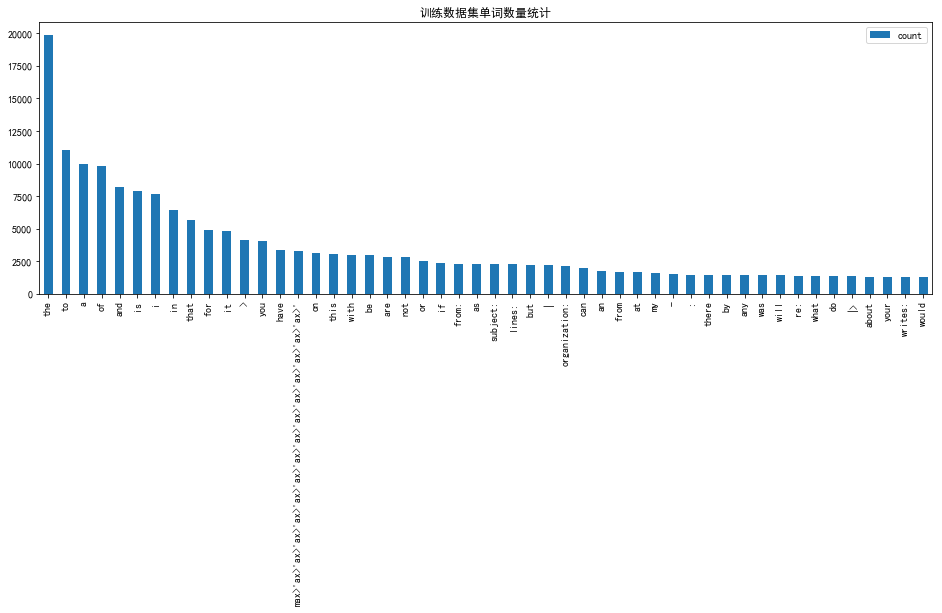

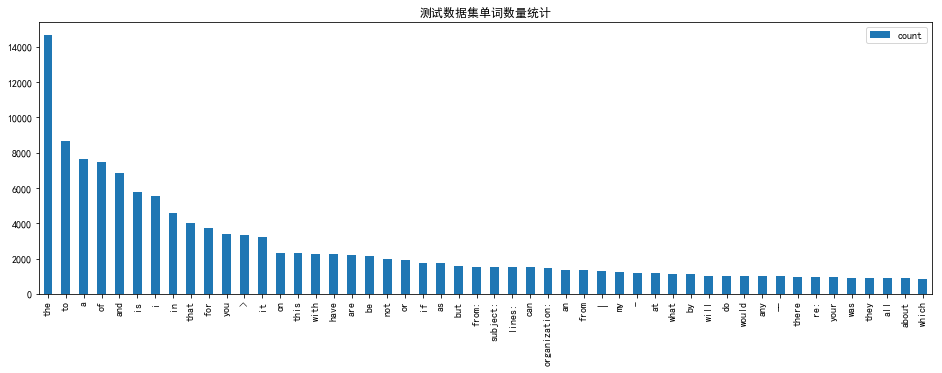

In [5]:
from collections import Counter  
# 将文档分词，并统计不同单词的数量
def get_topN_word(data):
    texts = [[word for word in document.lower().split()]  
              for document in data]  
    
    frequency = {}
    for text in texts:  
        for token in text:  
            if not token in frequency:
                frequency[token] = 0
            frequency[token] += 1
    

    word_counter = Counter(frequency)
    word_counter.most_common(50)
    train_texts_df = pd.DataFrame.from_dict(frequency,orient='index')
    train_texts_df.columns = ['count']
    train_texts_df.sort_values(['count'], ascending=False, inplace=True)
    top_n_words_df = train_texts_df.head(50)
    return top_n_words_df

train_top_n_words = get_topN_word(sub_train_news.data)
train_top_n_words.plot(kind='bar',figsize=(16,5))
plt.title('训练数据集单词数量统计')
plt.show()

test_top_n_words = get_topN_word(sub_test_news.data)
test_top_n_words.plot(kind='bar',figsize=(16,5))
plt.title('测试数据集单词数量统计')
plt.show()

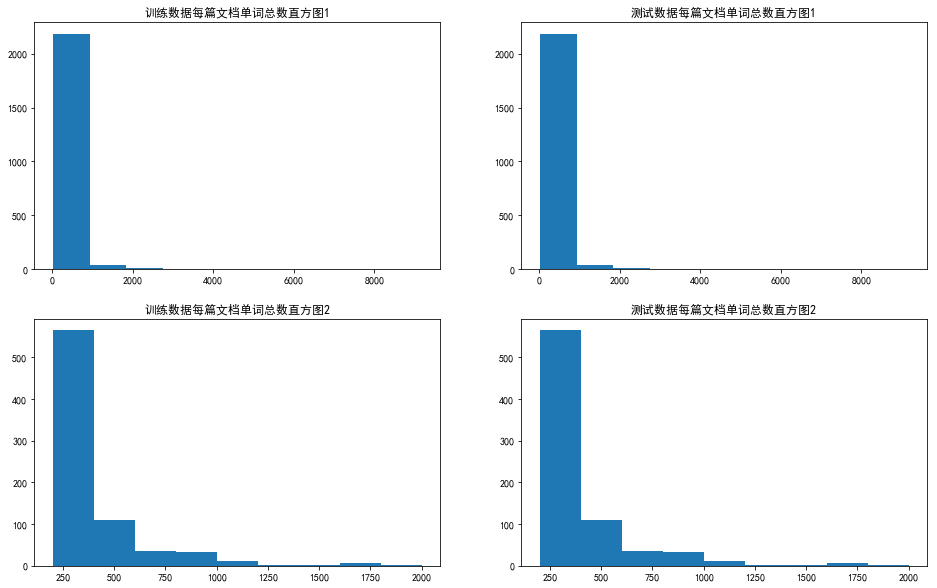

In [6]:
# 统计每篇文档单词总数
def count_doc_words(data):
    texts = [[word for word in document.lower().split()] for document in data]

    for index, text in enumerate(texts):
        texts[index] = len(text)
     
    return texts

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))
ax0, ax1, ax2, ax3= axes.flatten()
ax0.hist(count_doc_words(sub_train_news.data), 10)
ax0.set_title('训练数据每篇文档单词总数直方图1')
ax1.hist(count_doc_words(sub_train_news.data), 10)
ax1.set_title('测试数据每篇文档单词总数直方图1')

ax2.hist(count_doc_words(sub_train_news.data), [200,400,600,800,1000,1200,1400,1600,1800,2000])
ax2.set_title('训练数据每篇文档单词总数直方图2')
ax3.hist(count_doc_words(sub_train_news.data), [200,400,600,800,1000,1200,1400,1600,1800,2000])
ax3.set_title('测试数据每篇文档单词总数直方图2')
plt.show()

##  新闻文档分词预处理

In [14]:
def preprocessing_text(data):
    """
    @去除英文停用词,去除单词前后的特殊符号，去除仅出现一次的单词
    """
#     from nltk.corpus import stopwords  
#     english_stopwords = stopwords.words('english')  
#     # 数据来源：https://www.ranks.nl/stopwords
#     stoplist = [line.lower().strip() for line in open('englist_long_stop_words_v1.txt')]
#     english_stopwords.extend(stoplist)
#     # 数据来源：http://blog.csdn.net/shijiebei2009/article/details/39696523
#     stoplist = [line.lower().strip() for line in open('englist_long_stop_words_v2.txt')]
#     english_stopwords.extend(stoplist)
#     # # 扩展english_stopwords
#     # english_stopwords.extend(["i'm","that's",])
#     english_stopwords = list(set(english_stopwords))

#     english_punctuations = [',','.',':',';','?','!','(',')','[',']',
#                             '@','&','#','%','$','{','}','--','-','_','*','\\','\\\\','/','//','|','||','','>','<','+','"',"'",'=']
    from gensim.parsing.preprocessing import preprocess_string
   
    texts = []
    for document in data:
#         _doc = []
#         for word in document.lower().split():
           
#             while word:
#                 if word[0] in english_punctuations:
#                     word = word.strip(word[0])
#                 elif word[-1] in english_punctuations:
#                     word = word.strip(word[-1])
#                 else:
#                     break
#             if word and word not in english_stopwords:
#                 try:
#                     num = float(word)
#                 except ValueError:
#                     _doc.append(word)
        texts.append(preprocess_string(document))

    frequency = {}
    for text in texts:  
        for token in text:  
            if not token in frequency:
                frequency[token] = 0
            frequency[token] += 1

    texts = [[token for token in text if frequency[token] > 1] for text in texts]
    return texts, frequency


In [67]:
from gensim import corpora, models, similarities

sub_news_data = sub_train_news.data[:]
sub_news_data.extend(sub_test_news.data)
all_sub_texts, sub_train_frequency = preprocessing_text(sub_news_data)
sub_train_texts, _  = preprocessing_text(sub_train_news.data)
sub_test_texts, _ = preprocessing_text(sub_test_news.data)

# train_texts_df = pd.DataFrame.from_dict(sub_train_frequency, orient='index')
# train_texts_df.columns = ['count']
# train_texts_df.sort_values(['count'], ascending=False, inplace=True)
# train_top_n_words = train_texts_df.head(50)
# train_top_n_words.plot(kind='bar',figsize=(16,5))
# plt.title('数据集单词数量统计')


# test_texts_df = pd.DataFrame.from_dict(sub_test_frequency,orient='index')
# test_texts_df.columns = ['count']
# test_texts_df.sort_values(['count'], ascending=False, inplace=True)
# test_top_n_words = train_texts_df.head(50)
# test_top_n_words.plot(kind='bar',figsize=(16,5))
# plt.title('测试数据集单词数量统计')

# plt.show()


In [68]:
# 保存分词结果
dictionary = corpora.Dictionary(all_sub_texts)  
dictionary.save('texts.dict')
all_corpus = [dictionary.doc2bow(text) for text in all_sub_texts]
corpora.MmCorpus.serialize('texts.mm', all_corpus)
train_corpus = [dictionary.doc2bow(text) for text in sub_train_texts]  
corpora.MmCorpus.serialize('train_texts.mm', train_corpus)
test_corpus = [dictionary.doc2bow(text) for text in sub_test_texts]  
corpora.MmCorpus.serialize('test_texts.mm', test_corpus)

## 文档分类

In [69]:
# 加载语料库
import gensim
from gensim import corpora, models, similarities
from gensim import sklearn_api

all_sub_corpus = corpora.MmCorpus('texts.mm')
all_sub_dict = corpora.Dictionary.load('texts.dict')
# train_corpus = corpora.MmCorpus('train_texts.mm')
# test_corpus = corpora.MmCorpus('test_texts.mm')
tfidf = models.TfidfModel(dictionary=dictionary)
all_tfidf = tfidf[all_sub_corpus]
train_tfidf =  all_tfidf[sub_train_texts]
test_tfidf = all_tfidf[sub_test_texts]

# train_lsi = models.LsiModel(corpus = train_tfidf, 
#                             id2word = dictionary, 
#                             num_topics=100)
# test_lsi = models.LsiModel(corpus = test_tfidf,
#                           id2word = dictionary,
#                           num_topics=100)
# train_lsi_corpus = [train_lsi[doc] for doc in train_corpus]
# test_lsi_corpus = [test_lsi[doc] for doc in test_corpus]
len(dictionary.token2id)


18615

In [76]:
# 将gen
train_matrix = gensim.matutils.corpus2dense(train_corpus, num_terms=18615).T
test_matrix = gensim.matutils.corpus2dense(test_corpus, num_terms=18615).T
print(train_matrix.shape)
print(test_matrix.shape)

(2245, 18615)
(1494, 18615)


In [27]:
import scipy
data = []
rows = []
cols = []
line_count = 0
for line in skl_train_tfidf:  # lsi_corpus_total 是之前由gensim生成的lsi向量
    for elem in line:
        rows.append(line_count)
        cols.append(elem[0])
        data.append(elem[1])
    line_count += 1
train_matrix = scipy.sparse.csr_matrix((data,(rows,cols))) # 稀疏向量
train_matrix = train_matrix.toarray()  # 密集向量

data = []
rows = []
cols = []
line_count = 0
for line in skl_test_tfidf:  # lsi_corpus_total 是之前由gensim生成的lsi向量
    for elem in line:
        rows.append(line_count)
        cols.append(elem[0])
        data.append(elem[1])
    line_count += 1
test_matrix = scipy.sparse.csr_matrix((data,(rows,cols))) # 稀疏向量
test_matrix = test_matrix.toarray()  # 密集向量

In [65]:
print(train_matrix.shape)
print(test_matrix.shape)

(18615, 2245)
(18615, 2245)


In [77]:
from sklearn import svm
# clf = svm.SVC()  # 使用RBF核
clf = svm.LinearSVC() # 使用线性核
clf_res = clf.fit(train_matrix,sub_train_news.target)
test_pred   = clf_res.predict(test_matrix)
from sklearn import metrics


metrics.f1_score(sub_test_news.target, test_pred, average='macro')

0.85012858756748444

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
categories = ['alt.atheism', 'talk.religion.misc',
              'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      categories=categories)
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(newsgroups_train.data)
print(vectors.shape)
newsgroups_test = fetch_20newsgroups(subset='test',
                                      categories=categories)
vectors_test = vectorizer.transform(newsgroups_test.data)
print(vectors_test.shape)

(2034, 34118)
(1353, 34118)


In [73]:
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

clf = MultinomialNB(alpha=.01)
clf.fit(train_matrix, sub_train_news.target)
pred = clf.predict(test_matrix)
metrics.f1_score(sub_test_news.target, pred, average='macro')

ValueError: Input X must be non-negative

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()

newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
train_vectors = vectorizer.fit_transform(newsgroups_train.data)
test_vectors = vectorizer.fit_transform(newsgroups_test.data)
print(train_vectors.shape)
print(test_vectors.shape)

(2245, 49914)
(1494, 32298)


In [20]:
# Bayes 模型
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
clf = MultinomialNB(alpha=.01)
clf.fit(train_vectors,newsgroups_train.target)
pred = clf.predict(test_vectors)
metrics.f1_score(newsgroups_test.target, pred, average='macro')

ValueError: dimension mismatch

In [248]:
# 创建TFid模型
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus[0]]
# # 潜在语义索引
# # 初始化一个LSI转换
# lsi = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=20)
# corpus_lsi = lsi[corpus_tfidf]
print(corpus_tfidf)

[(0, 0.125809008156427), (1, 0.2056544187664825), (2, 0.4124270971457829), (3, 0.09215040667890322), (4, 0.2502053896610919), (5, 0.1596982268043184), (6, 0.1235333199320718), (7, 0.12826904986516552), (8, 0.22446237114200343), (9, 0.11394344709819301), (10, 0.21682681311239507), (11, 0.09110924564196152), (12, 0.2625244291333535), (13, 0.16861086362083316), (14, 0.09949271810723821), (15, 0.1301567680649149), (16, 0.11902935150620039), (17, 0.19576727603595967), (18, 0.1359307658728887), (19, 0.108710187668963), (20, 0.1177081655404318), (21, 0.10006598963733848), (22, 0.2835839662097888), (23, 0.1188946174064464), (24, 0.12719026826871485), (25, 0.13454950576060085), (26, 0.15583493599437961), (27, 0.0771135054669487), (28, 0.15538481680305477), (29, 0.14554735926709375), (30, 0.11260282566737427), (31, 0.10648608599995744), (32, 0.23468523540669153), (33, 0.10223977022479036)]


In [ ]:
# 相似度查询
word = 'people'


In [27]:
import tensorflow as tf
my_graph = tf.Graph()
with tf.Session(graph=my_graph) as sess:
    x = tf.constant([1,3,6]) 
    y = tf.constant([1,1,1])
    op = tf.add(x,y)
    result = sess.run(fetches=op)
    print(result)

[2 4 7]


In [29]:
vocab = Counter()

text = "Hi from Brazil"

for word in text.split(' '):
    word_lowercase = word.lower()
    vocab[word_lowercase]+=1
        
def get_word_2_index(vocab):
    word2index = {}
    for i,word in enumerate(vocab):
        word2index[word] = i
        
    return word2index
word2index = get_word_2_index(vocab)

total_words = len(vocab)
matrix = np.zeros((total_words),dtype=float)

for word in text.split():
    matrix[word2index[word.lower()]] += 1
    
print("Hi from Brazil:", matrix)

matrix = np.zeros((total_words),dtype=float)
text = "Hi"
for word in text.split():
    matrix[word2index[word.lower()]] += 1
    
print("Hi:", matrix)

Hi from Brazil: [ 1.  1.  1.]
Hi: [ 1.  0.  0.]


In [31]:
categories = ["comp.graphics","sci.space","rec.sport.baseball"]
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test', categories=categories)
print('total texts in train:',len(newsgroups_train.data))
print('total texts in test:',len(newsgroups_test.data))
print('text',newsgroups_train.data[0])
print('category:',newsgroups_train.target[0])

total texts in train: 1774
total texts in test: 1180
text From: jk87377@lehtori.cc.tut.fi (Kouhia Juhana)
Subject: Re: More gray levels out of the screen
Organization: Tampere University of Technology
Lines: 21
Distribution: inet
NNTP-Posting-Host: cc.tut.fi

In article <1993Apr6.011605.909@cis.uab.edu> sloan@cis.uab.edu
(Kenneth Sloan) writes:
>
>Why didn't you create 8 grey-level images, and display them for
>1,2,4,8,16,32,64,128... time slices?

By '8 grey level images' you mean 8 items of 1bit images?
It does work(!), but it doesn't work if you have more than 1bit
in your screen and if the screen intensity is non-linear.

With 2 bit per pixel; there could be 1*c_1 + 4*c_2 timing,
this gives 16 levels, but they are linear if screen intensity is
linear.
With 1*c_1 + 2*c_2 it works, but we have to find the best
compinations -- there's 10 levels, but 16 choises; best 10 must be
chosen. Different compinations for the same level, varies a bit, but
the levels keeps their order.

Readers s

In [32]:
vocab = Counter()

for text in newsgroups_train.data:
    for word in text.split(' '):
        vocab[word.lower()]+=1
        
for text in newsgroups_test.data:
    for word in text.split(' '):
        vocab[word.lower()]+=1

In [33]:
print("Total words:",len(vocab))

Total words: 119930


In [34]:
total_words = len(vocab)

def get_word_2_index(vocab):
    word2index = {}
    for i,word in enumerate(vocab):
        word2index[word.lower()] = i
        
    return word2index

word2index = get_word_2_index(vocab)

print("Index of the word 'the':",word2index['the'])

Index of the word 'the': 10


In [35]:
def get_batch(df,i,batch_size):
    batches = []
    results = []
    texts = df.data[i*batch_size:i*batch_size+batch_size]
    categories = df.target[i*batch_size:i*batch_size+batch_size]
    for text in texts:
        layer = np.zeros(total_words,dtype=float)
        for word in text.split(' '):
            layer[word2index[word.lower()]] += 1
            
        batches.append(layer)
        
    for category in categories:
        y = np.zeros((3),dtype=float)
        if category == 0:
            y[0] = 1.
        elif category == 1:
            y[1] = 1.
        else:
            y[2] = 1.
        results.append(y)
            
     
    return np.array(batches),np.array(results)

In [40]:
# Parameters
learning_rate = 0.01
training_epochs = 10
batch_size = 64
display_step = 1

# Network Parameters
n_hidden_1 = 100      # 1st layer number of features
n_hidden_2 = 100       # 2nd layer number of features
n_input = total_words # Words in vocab
n_classes = 3         # Categories: graphics, sci.space and baseball

input_tensor = tf.placeholder(tf.float32,[None, n_input],name="input")
output_tensor = tf.placeholder(tf.float32,[None, n_classes],name="output") 
def multilayer_perceptron(input_tensor, weights, biases):
    layer_1_multiplication = tf.matmul(input_tensor, weights['h1'])
    layer_1_addition = tf.add(layer_1_multiplication, biases['b1'])
    layer_1 = tf.nn.relu(layer_1_addition)
    
    # Hidden layer with RELU activation
    layer_2_multiplication = tf.matmul(layer_1, weights['h2'])
    layer_2_addition = tf.add(layer_2_multiplication, biases['b2'])
    layer_2 = tf.nn.relu(layer_2_addition)
    
    # Output layer 
    out_layer_multiplication = tf.matmul(layer_2, weights['out'])
    out_layer_addition = out_layer_multiplication + biases['out']
    
    return out_layer_addition

In [41]:
# Store layers weight & bias
weights = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_hidden_2, n_classes]))
}
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

# Construct model
prediction = multilayer_perceptron(input_tensor, weights, biases)

# Define loss and optimizer
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=prediction, labels=output_tensor))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

# Initializing the variables
init = tf.global_variables_initializer()

In [42]:
# Launch the graph
with tf.Session() as sess:
    sess.run(init)

    # Training cycle
    for epoch in range(training_epochs):
        avg_cost = 0.
        total_batch = int(len(newsgroups_train.data)/batch_size)
        # Loop over all batches
        for i in range(total_batch):
            batch_x,batch_y = get_batch(newsgroups_train,i,batch_size)
            # Run optimization op (backprop) and cost op (to get loss value)
            c,_ = sess.run([loss,optimizer], feed_dict={input_tensor: batch_x,output_tensor:batch_y})
            # Compute average loss
            avg_cost += c / total_batch
        # Display logs per epoch step
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "loss=", \
                "{:.9f}".format(avg_cost))
    print("Optimization Finished!")

    # Test model
    correct_prediction = tf.equal(tf.argmax(prediction, 1), tf.argmax(output_tensor, 1))
    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    total_test_data = len(newsgroups_test.target)
    batch_x_test,batch_y_test = get_batch(newsgroups_test,0,total_test_data)
    print("Accuracy:", accuracy.eval({input_tensor: batch_x_test, output_tensor: batch_y_test}))

Epoch: 0001 loss= 700.311167399
Epoch: 0002 loss= 60.233710404
Epoch: 0003 loss= 24.650480838
Epoch: 0004 loss= 139.946975286
Epoch: 0005 loss= 39.165880672
Epoch: 0006 loss= 3.527348368
Epoch: 0007 loss= 26.433479839
Epoch: 0008 loss= 58.391109323
Epoch: 0009 loss= 3.259120054
Epoch: 0010 loss= 2.170379921
Optimization Finished!
Accuracy: 0.74322
